# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

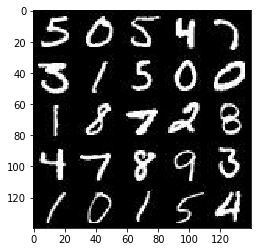

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import matplotlib.pyplot as plt

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

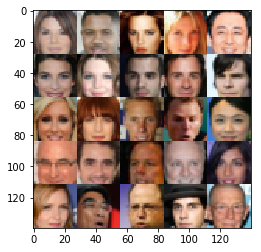

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # Real image inputs
    input_real = tf.placeholder(tf.float32, (None, *(image_width, image_height, image_channels)), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    stddev = 0.02
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                              kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same',
                                        kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',
                                            kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=(1 - smooth) * tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
        
    input_real, input_z, learning_rate_tensor = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    n_samples, width, height, channels = data_shape

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Sample random noise for G
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                
                if steps % show_every == 0:    
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)
            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.7562... Generator Loss: 0.0597
Epoch 1/2... Discriminator Loss: 1.7712... Generator Loss: 2.3912
Epoch 1/2... Discriminator Loss: 1.5130... Generator Loss: 1.6538
Epoch 1/2... Discriminator Loss: 1.2727... Generator Loss: 0.7324
Epoch 1/2... Discriminator Loss: 1.2828... Generator Loss: 0.7234
Epoch 1/2... Discriminator Loss: 1.2347... Generator Loss: 0.7499
Epoch 1/2... Discriminator Loss: 1.2074... Generator Loss: 1.0486
Epoch 1/2... Discriminator Loss: 1.7812... Generator Loss: 0.3116
Epoch 1/2... Discriminator Loss: 1.0894... Generator Loss: 1.1815
Epoch 1/2... Discriminator Loss: 1.3179... Generator Loss: 0.5510


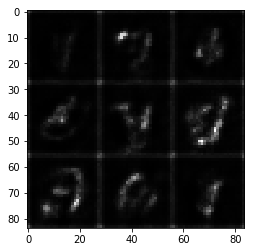

Epoch 1/2... Discriminator Loss: 0.9271... Generator Loss: 1.2026
Epoch 1/2... Discriminator Loss: 0.8975... Generator Loss: 1.6396
Epoch 1/2... Discriminator Loss: 0.9834... Generator Loss: 1.0035
Epoch 1/2... Discriminator Loss: 1.0699... Generator Loss: 0.9130
Epoch 1/2... Discriminator Loss: 0.9399... Generator Loss: 1.6639
Epoch 1/2... Discriminator Loss: 1.1438... Generator Loss: 1.5526
Epoch 1/2... Discriminator Loss: 1.1521... Generator Loss: 0.7538
Epoch 1/2... Discriminator Loss: 1.1733... Generator Loss: 0.7957
Epoch 1/2... Discriminator Loss: 1.2271... Generator Loss: 0.6556
Epoch 1/2... Discriminator Loss: 1.5346... Generator Loss: 2.5523


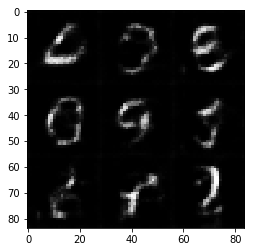

Epoch 1/2... Discriminator Loss: 1.0915... Generator Loss: 0.8387
Epoch 1/2... Discriminator Loss: 1.2004... Generator Loss: 0.6773
Epoch 1/2... Discriminator Loss: 1.2294... Generator Loss: 1.9192
Epoch 1/2... Discriminator Loss: 1.0367... Generator Loss: 1.4509
Epoch 1/2... Discriminator Loss: 1.8757... Generator Loss: 0.2785
Epoch 1/2... Discriminator Loss: 1.1664... Generator Loss: 0.7037
Epoch 1/2... Discriminator Loss: 1.2052... Generator Loss: 1.6889
Epoch 1/2... Discriminator Loss: 1.1821... Generator Loss: 1.9746
Epoch 1/2... Discriminator Loss: 1.3904... Generator Loss: 0.5065
Epoch 1/2... Discriminator Loss: 1.1210... Generator Loss: 0.7830


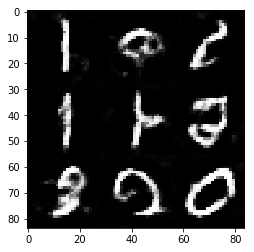

Epoch 1/2... Discriminator Loss: 1.0214... Generator Loss: 1.4693
Epoch 1/2... Discriminator Loss: 0.9776... Generator Loss: 1.5796
Epoch 1/2... Discriminator Loss: 1.2984... Generator Loss: 0.5795
Epoch 1/2... Discriminator Loss: 1.1193... Generator Loss: 0.7314
Epoch 1/2... Discriminator Loss: 1.2964... Generator Loss: 2.2064
Epoch 1/2... Discriminator Loss: 0.9228... Generator Loss: 1.1383
Epoch 1/2... Discriminator Loss: 1.1426... Generator Loss: 1.9627
Epoch 1/2... Discriminator Loss: 0.9191... Generator Loss: 1.2138
Epoch 1/2... Discriminator Loss: 0.9945... Generator Loss: 1.3221
Epoch 1/2... Discriminator Loss: 1.8608... Generator Loss: 0.3147


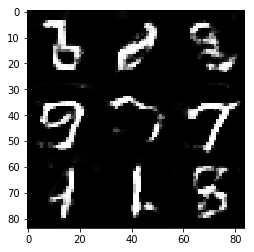

Epoch 1/2... Discriminator Loss: 0.9402... Generator Loss: 1.2960
Epoch 1/2... Discriminator Loss: 0.9410... Generator Loss: 1.2417
Epoch 1/2... Discriminator Loss: 0.9642... Generator Loss: 1.6306
Epoch 1/2... Discriminator Loss: 1.1919... Generator Loss: 0.6576
Epoch 1/2... Discriminator Loss: 1.1773... Generator Loss: 0.6792
Epoch 1/2... Discriminator Loss: 1.7028... Generator Loss: 2.9787
Epoch 2/2... Discriminator Loss: 0.8897... Generator Loss: 1.3936
Epoch 2/2... Discriminator Loss: 0.9667... Generator Loss: 0.9922
Epoch 2/2... Discriminator Loss: 0.8709... Generator Loss: 1.2957
Epoch 2/2... Discriminator Loss: 1.0507... Generator Loss: 0.8641


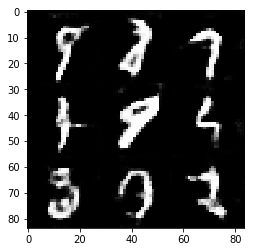

Epoch 2/2... Discriminator Loss: 1.4941... Generator Loss: 0.5165
Epoch 2/2... Discriminator Loss: 0.8869... Generator Loss: 1.1242
Epoch 2/2... Discriminator Loss: 0.9051... Generator Loss: 1.5426
Epoch 2/2... Discriminator Loss: 0.7718... Generator Loss: 1.4602
Epoch 2/2... Discriminator Loss: 1.5281... Generator Loss: 3.3835
Epoch 2/2... Discriminator Loss: 1.1097... Generator Loss: 0.8440
Epoch 2/2... Discriminator Loss: 1.1033... Generator Loss: 1.1905
Epoch 2/2... Discriminator Loss: 1.0236... Generator Loss: 0.8634
Epoch 2/2... Discriminator Loss: 0.9856... Generator Loss: 1.7221
Epoch 2/2... Discriminator Loss: 0.9118... Generator Loss: 1.0198


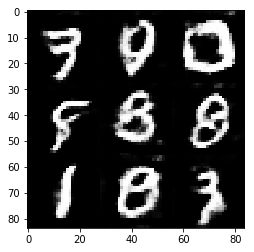

Epoch 2/2... Discriminator Loss: 0.8098... Generator Loss: 2.1633
Epoch 2/2... Discriminator Loss: 0.8587... Generator Loss: 1.3061
Epoch 2/2... Discriminator Loss: 0.9581... Generator Loss: 0.9348
Epoch 2/2... Discriminator Loss: 1.7359... Generator Loss: 2.2306
Epoch 2/2... Discriminator Loss: 1.0197... Generator Loss: 0.9150
Epoch 2/2... Discriminator Loss: 0.8873... Generator Loss: 1.8813
Epoch 2/2... Discriminator Loss: 0.8557... Generator Loss: 1.6607
Epoch 2/2... Discriminator Loss: 0.8084... Generator Loss: 1.2576
Epoch 2/2... Discriminator Loss: 0.9824... Generator Loss: 1.0025
Epoch 2/2... Discriminator Loss: 1.3959... Generator Loss: 2.0910


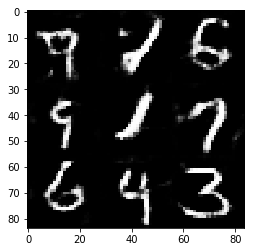

Epoch 2/2... Discriminator Loss: 1.0213... Generator Loss: 0.9059
Epoch 2/2... Discriminator Loss: 1.2201... Generator Loss: 0.6741
Epoch 2/2... Discriminator Loss: 0.8333... Generator Loss: 1.2033
Epoch 2/2... Discriminator Loss: 0.9365... Generator Loss: 0.9290
Epoch 2/2... Discriminator Loss: 1.3378... Generator Loss: 0.6290
Epoch 2/2... Discriminator Loss: 1.1425... Generator Loss: 0.7229
Epoch 2/2... Discriminator Loss: 0.9256... Generator Loss: 1.0686
Epoch 2/2... Discriminator Loss: 0.9758... Generator Loss: 0.9218
Epoch 2/2... Discriminator Loss: 1.4155... Generator Loss: 2.7730
Epoch 2/2... Discriminator Loss: 1.0735... Generator Loss: 0.7968


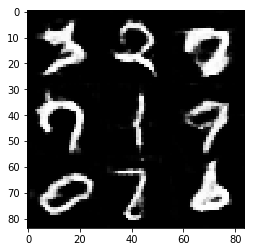

Epoch 2/2... Discriminator Loss: 0.7101... Generator Loss: 1.5950
Epoch 2/2... Discriminator Loss: 0.7795... Generator Loss: 1.8965
Epoch 2/2... Discriminator Loss: 0.8929... Generator Loss: 1.0447
Epoch 2/2... Discriminator Loss: 1.0560... Generator Loss: 0.8595
Epoch 2/2... Discriminator Loss: 0.9301... Generator Loss: 1.0462
Epoch 2/2... Discriminator Loss: 0.8642... Generator Loss: 1.1731
Epoch 2/2... Discriminator Loss: 0.7518... Generator Loss: 1.4385
Epoch 2/2... Discriminator Loss: 0.6872... Generator Loss: 1.5381
Epoch 2/2... Discriminator Loss: 0.8288... Generator Loss: 2.1057
Epoch 2/2... Discriminator Loss: 0.6678... Generator Loss: 1.5848


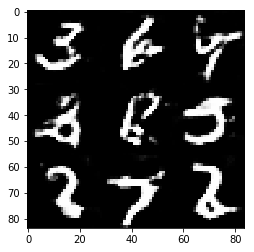

Epoch 2/2... Discriminator Loss: 0.7534... Generator Loss: 1.3563
Epoch 2/2... Discriminator Loss: 1.0007... Generator Loss: 0.9813
Epoch 2/2... Discriminator Loss: 0.6649... Generator Loss: 1.6326


In [14]:
learning_rate = 0.0005
z_dim = 100
batch_size = 128
beta1 = 0.5
n_images = 10
data_image_mode = 'L'
print_every = 10
show_every = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 1.5664
Epoch 1/1... Discriminator Loss: 1.8003... Generator Loss: 8.4280
Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 0.5104
Epoch 1/1... Discriminator Loss: 0.8479... Generator Loss: 1.2944
Epoch 1/1... Discriminator Loss: 0.7053... Generator Loss: 1.8854
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 0.7750... Generator Loss: 1.7712
Epoch 1/1... Discriminator Loss: 0.5639... Generator Loss: 1.9565
Epoch 1/1... Discriminator Loss: 1.5703... Generator Loss: 0.4853
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 0.9703


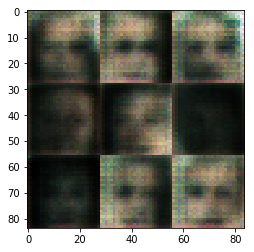

Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 2.9119... Generator Loss: 4.0772
Epoch 1/1... Discriminator Loss: 2.6875... Generator Loss: 0.1424
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 1.4423
Epoch 1/1... Discriminator Loss: 0.6971... Generator Loss: 2.1812
Epoch 1/1... Discriminator Loss: 1.8744... Generator Loss: 1.9741
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.8784


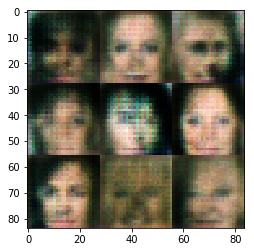

Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.7003... Generator Loss: 5.5767
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 1.0890
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 1.0878
Epoch 1/1... Discriminator Loss: 0.9889... Generator Loss: 1.1804
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 0.9348


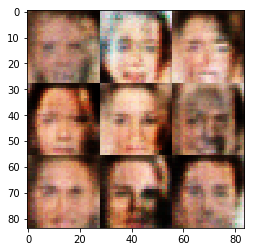

Epoch 1/1... Discriminator Loss: 1.7467... Generator Loss: 0.3216
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.4965
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 1.1413
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 1.6767
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 2.1754... Generator Loss: 4.0868


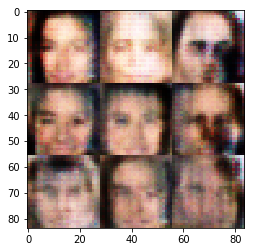

Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 1.2921
Epoch 1/1... Discriminator Loss: 1.6931... Generator Loss: 0.3745
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 1.0908
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 1.1036
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 1.8466
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 2.4252


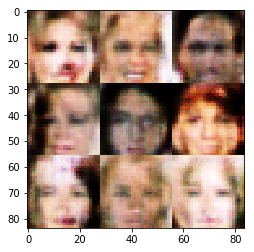

Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 1.0260
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 0.6980... Generator Loss: 2.4173
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 1.7260
Epoch 1/1... Discriminator Loss: 2.5378... Generator Loss: 2.0314
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.7855


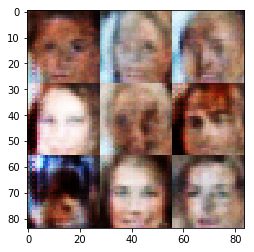

Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 1.1230
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 0.9705... Generator Loss: 2.3221
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 1.1560
Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 1.0582
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.9310


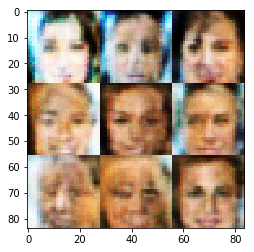

Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 1.0638
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.5539
Epoch 1/1... Discriminator Loss: 0.8774... Generator Loss: 1.8825
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 1.2016
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.3168
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.6459


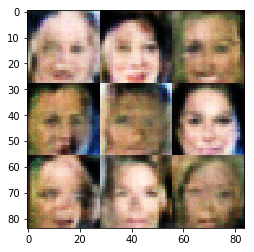

Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.9947
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.8126... Generator Loss: 1.5694
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 1.0339
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.9321... Generator Loss: 2.5168
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.6624


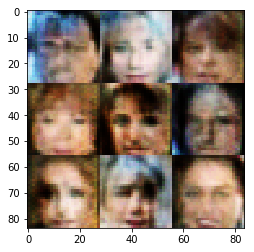

Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 1.1959
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.4637
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 1.2486
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 1.2796
Epoch 1/1... Discriminator Loss: 0.8594... Generator Loss: 1.3428
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 1.0818
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.5427


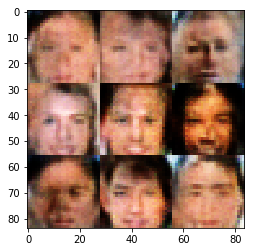

Epoch 1/1... Discriminator Loss: 0.9620... Generator Loss: 1.3709
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 1.6173
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 2.1643
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 1.0351
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 2.3836
Epoch 1/1... Discriminator Loss: 2.2113... Generator Loss: 2.9011
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.8520


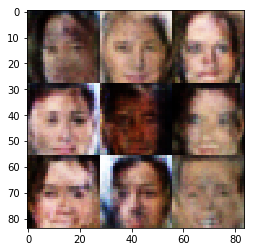

Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 1.1818
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.6109... Generator Loss: 1.4607
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.7732


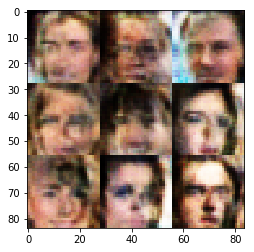

Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 1.0635
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 1.0644
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 1.9309
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 1.1309
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 1.1910
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.6152


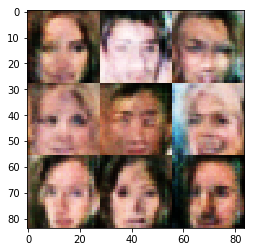

Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.4960
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 1.3111
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 1.3701
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.9616


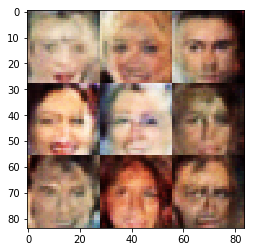

Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.5258
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 0.9659
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 1.6294... Generator Loss: 0.4723
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 1.4401


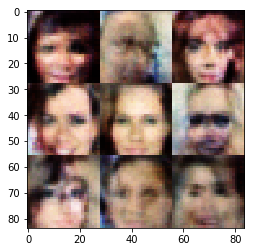

Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 1.0763
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.5342
Epoch 1/1... Discriminator Loss: 1.6708... Generator Loss: 2.2472
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 1.5980
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.6314


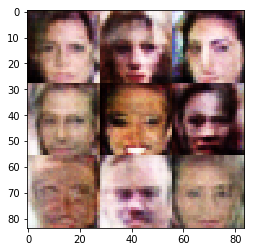

Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.3782
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 1.4087
Epoch 1/1... Discriminator Loss: 1.5711... Generator Loss: 1.4627
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.8514


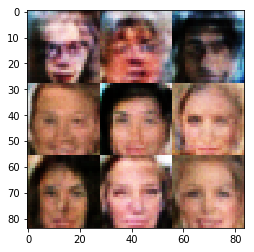

Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 1.7015... Generator Loss: 0.3375
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 1.1662
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 0.9976
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 1.7216


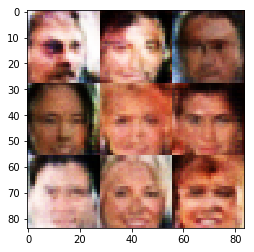

Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 1.5010
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 1.6554
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 1.0273
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 0.9521
Epoch 1/1... Discriminator Loss: 1.8579... Generator Loss: 0.2896


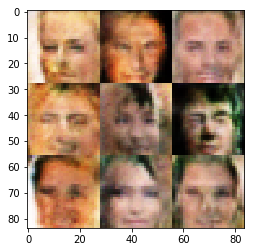

Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 1.1963
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 1.5383
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 1.2577
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 1.9445
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.4772
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.5469


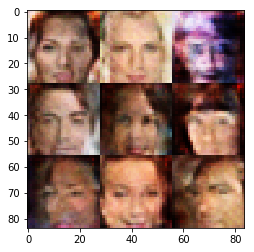

Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 1.3196
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 1.0708
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 1.2149
Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 0.8116


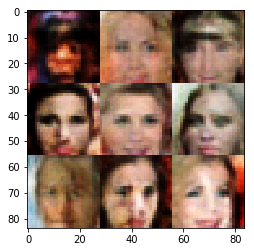

Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 1.1133
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.2312
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.4562
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 0.9505
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 0.7406


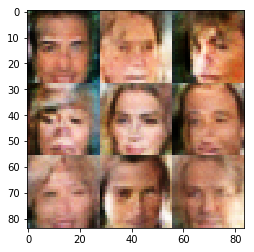

Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 1.0112
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 1.1239
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.4965
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 1.2200
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.9753
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.3567
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 1.1283
Epoch 1/1... Discriminator Loss: 1.6102... Generator Loss: 0.4086


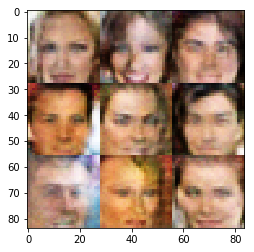

Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.4729
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 1.2261
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 1.3386


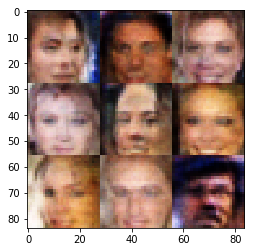

Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 1.2757
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 1.4747
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 1.6044... Generator Loss: 0.3884
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 1.0696
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 1.2536
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 1.2872


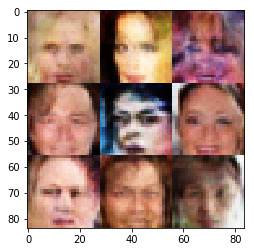

Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 1.6281
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 1.3388
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 1.0208
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.4844
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 1.3852
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.0086
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 1.0036
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 1.6628


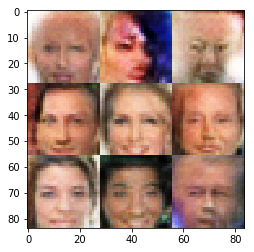

Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 1.2828
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.5455
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 1.5627
Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.6224... Generator Loss: 1.3615
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 1.4193


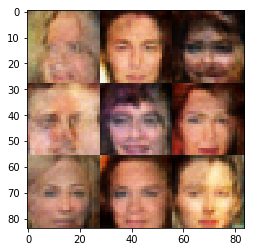

Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 1.3564
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.0613
Epoch 1/1... Discriminator Loss: 1.6193... Generator Loss: 0.3897
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 1.1318
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.5906... Generator Loss: 0.4195
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.6093... Generator Loss: 0.4086
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.5718


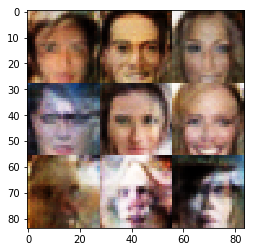

Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.5258
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 1.0777
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 1.3412
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.9842
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 1.3327
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.9062


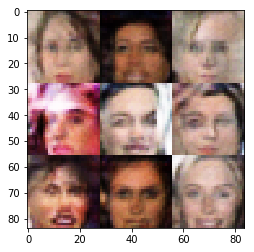

Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 0.9158... Generator Loss: 1.3148
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 0.9322
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.6397


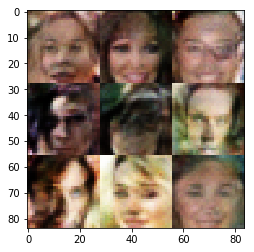

Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 1.8160
Epoch 1/1... Discriminator Loss: 1.6492... Generator Loss: 0.3700
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.5888


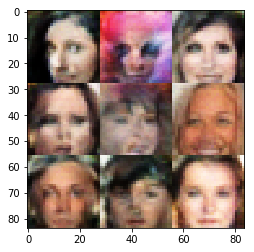

Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.4429
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 1.1522


In [15]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5
n_images = 10
data_image_mode = 'RGB'
print_every = 10
show_every = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.